# Poisson's problem
---

## Introduction

## In this first tutorial we

1.   Present a basic implementation of the finite element solution of Poisson's problem
2.   Import all necessary libraries to solve the problem with the FEniCSx platform
3.   Solve the problem with different grid refinements
4.   Visualize the solution using Paraview
5.   Perform some postprocessing



**Mathematical formulation:**

  Let us recall the mathematical formulation of the Poisson's problem with
  Dirichlet and Neumann boundary conditions. In differential form: Find ${u}$ such that

\begin{equation}
\left \{
\begin{array}{rcll}
-\nabla \cdot [ \mu(\mathbf{x}) \nabla{u}(\mathbf{x})] & = & f(\mathbf{x}) &  \mbox{in}~\Omega \\
&& \\
{u}(\mathbf{x}) & = & g_D(\mathbf{x}) &  \mbox{in}~\partial\Omega_D \\
&& \\
-\mu(\mathbf{x}) \nabla{u}(\mathbf{x})\cdot\check{\mathbf{n}} & = & g_N(\mathbf{x}) &  \mbox{in}~\partial\Omega_N \\
\end{array}
\right.
\end{equation}

or by multiplying by a sufficiently regular test function $v$ and
applying integration by parts. in variational form: Find $u \in V_g(\Omega)$ such that

\begin{equation}
\underbrace{{\int_{\Omega}}{\mu(\mathbf{x})\,\nabla{u}(\mathbf{x})\cdot \nabla{v}(\mathbf{x})}\,dx}_{a(u,v)} =
        \underbrace{\int_{\Omega}{f(\mathbf{x})\,v(\mathbf{x})}\,dx
        -\int_{\partial\Omega_N}{g_N(\mathbf{x})\,v(\mathbf{x})}\,ds}_{\ell(v)}~~~\forall v \in V_0(\Omega)
\end{equation}

where $a(\cdot,\cdot)$ is a bilinear form and
$\ell(\cdot)$ is a linear form and the space $V_g$ is

$$
V_g = \{v \in H^1(\Omega),~~v(\mathbf{x}) = g_D(\mathbf{x})~\forall \mathbf{x} \in \partial{\Omega}_D  \}
$$

Finally, recall that the discrete version of this problem follows from applying the Galerkin method: Find $u_h \in V_{hg} \subset V_g(\Omega)$ such that

\begin{equation}
a(u_h,v_h) = \ell(v_h)~~ \forall v_h \in V_{h0}
\end{equation}

## Initialization

The first step is to import all necessary libraries. In particular, we must import
the [`FEniCSx`](https://fenicsproject.org/) library, which can be done now in Colab thanks to the efforts of the
[`FEM on Colab`](https://fem-on-colab.github.io/).
Notice that the first time the library is imported, the system may take a while. Following times are expected to be faster.

Once the `DOLFINx` package (the main library of the `FEniCSx` project) is installed, we must import some of its modules.

Relevant `DOLFINx` modules:
- `dolfinx.mesh`: Classes and functions related to the computational domain
- `dolfinx.fem`: Finite element method functionality
- `dolfinx.io`: Input/Output (read/write) functionality
- `dolfinx.plot`: Convenience functions for exporting plotting data

In [1]:
arch=" "
try:
    import google.colab  # noqa: F401
except ImportError:
    import ufl
    import dolfinx
else:
    try:
        import ufl
        import dolfinx
    except ImportError:
        if arch != "complex":
            !wget "https://fem-on-colab.github.io/releases/fenicsx-install-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
        else:
            !wget "https://fem-on-colab.github.io/releases/fenicsx-install-complex.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
        import ufl
        import dolfinx

try:
    import gmsh
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"
    import gmsh


--2024-04-10 19:11:22--  https://fem-on-colab.github.io/releases/fenicsx-install-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4319 (4.2K) [application/x-sh]
Saving to: ‘/tmp/fenicsx-install.sh’

/tmp/fenicsx-instal 100%[===================>]   4.22K  --.-KB/s    in 0s      

2024-04-10 19:11:22 (43.8 MB/s) - ‘/tmp/fenicsx-install.sh’ saved [4319/4319]

+ INSTALL_PREFIX=/usr/local
++ awk -F/ '{print NF-1}'
++ echo /usr/local
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICSX_INSTALLED=/usr/local/share/fem-on-colab/fenicsx.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenicsx.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/c3d2317/releases/pybind1

In [3]:
try:
    import pyvista
except ImportError:
    !pip install - q piglet pyvirtualdisplay ipyvtklink pyvista panel
    !apt-get - qq install xvfb
    import pyvista



In [5]:
from dolfinx import mesh, fem, io, plot

We must also import the [`Unified Form Language`](https://github.com/FEniCS/ufl/) (`UFL`) library
which provides us a specific language for writting variational formulations as well as the required mathematical operators

In [6]:
from ufl import SpatialCoordinate, TestFunction, TrialFunction, Measure, dx, ds, grad, inner, as_vector, FacetNormal

Finally, we import some auxiliary libraries:

In [7]:
import numpy as np
from mpi4py import MPI
import pyvista
from petsc4py.PETSc import ScalarType

## Problem definition


The first thing is to define the computational domain and parts of the boundary on which the Dirichlet conditions are to be applied:

In [8]:
# Computational mesh
Lx, Ly = 1.0, 1.0
msh = mesh.create_rectangle(comm=MPI.COMM_WORLD,
                            points=((0.0, 0.0), (Lx, Ly)), n=(64, 64),
                            cell_type=mesh.CellType.triangle)
plot.vtk_mesh(msh)

(array([   3,    0,    1, ..., 4222, 4224, 4223], dtype=int32),
 array([5, 5, 5, ..., 5, 5, 5]),
 array([[0.984375, 0.      , 0.      ],
        [1.      , 0.      , 0.      ],
        [1.      , 0.015625, 0.      ],
        ...,
        [0.      , 0.984375, 0.      ],
        [0.015625, 1.      , 0.      ],
        [0.      , 1.      , 0.      ]]))

In [9]:
import IPython

def plot_mesh(mesh, cell_values=None, filename="file.html"):
    pyvista.start_xvfb()
    grid = pyvista.UnstructuredGrid(*plot.vtk_mesh(mesh))
    plotter = pyvista.Plotter(notebook=True, window_size=[500,500])

    if cell_values is not None:
        min_ = cell_values.x.array.min()
        max_ = cell_values.x.array.max()
        grid.cell_data["cell_values"] = cell_values.x.array
        viridis = plt.colormaps.get_cmap("viridis")
        plotter.add_mesh(grid, cmap=viridis, show_edges=True, clim=[min_, max_])
    else:
        plotter.add_mesh(grid, show_edges=True)

    plotter.camera.zoom(2.0)
    plotter.view_xy()
    plotter.export_html(filename)
    plotter.close()


plot_mesh(msh, cell_values = None, filename="mesh.html")
IPython.display.HTML(filename="mesh.html")

## Finite element solution

We must create now the discrete function space associated to a conforming finite element partition $\mathcal{T}_h$ of $\Omega$, ***the mesh***, in which the solution is sought.

For this problem, the natural choice is a space of continuous functions, that are elementwise polynomials of degree $k$

$$
V(\mathcal{T}_h) = V_h = \{v \in H^1(\Omega),~v|_E \in P_k(E) \, \forall E \in \mathcal{T}_h\}
$$


In [10]:
degree = 1
V = fem.functionspace(msh, ("CG", degree))

Above, `CG` refers to Continuous Galerkin, which is just another name for the widely used *Lagrange* spaces in the FEM, so, the following would be equivalent:

    V = fem.FunctionSpace(msh, ("Lagrange", degree))

For the $P_1$ Lagrangian space, the dofs are simply the function values
at the vertices of the triangulation, a discrete function
$\mathbf{u}_h\in V_h$ is written as

$$
u_h = \sum_{i=1}^{dim{V_h}}{u_j \psi_j}
$$
where $\{\psi_j\}_{j=1}^{dim{V_h}}$ are a set of basis functions for $V_h$, so the global vector of unknowns $\boldsymbol{\mathsf{U}} \in \mathbb{R}^{dimV_h}$.

---

Now, we identify the parts of the boundary on which
Dirichlet conditions are given and define the corresponding objects. In `FEniCSx` we can identify degress of freedom $u_j$'s located on the boundary:

*   geometrically, or
*   topologically

in this case, we use geometric detection:

In [12]:
# Boundary values
uleft = 100.0
uright = 1.0

# Identify the degrees of freedom to which the values are to be applied
dofsL = fem.locate_dofs_geometrical(V, lambda x: np.isclose(x[0], 0))
dofsR = fem.locate_dofs_geometrical(V, lambda x: np.isclose(x[0], Lx))

# Define the Dirichlet type BCs as a list
bcs = [fem.dirichletbc(ScalarType(uleft), dofsL, V), fem.dirichletbc(ScalarType(uright), dofsR, V)]


Finally, we can write the variational formulation of our problem and solve, recalling

$$
a(u,v) = \int_{\Omega}{\mu\,\nabla{u}\cdot \nabla{v}}\,dx
$$
and, if we take $g_N = 0$, we naturally have
$$
\ell(v) = \int_{\Omega}{f\,v}\,dx
$$

In [13]:
from dolfinx.fem.petsc import LinearProblem
# Variational formulation

# Trial and test functions
u = TrialFunction(V)
v = TestFunction(V)

# Bilinear form
mu = fem.Constant(msh, 1.0)
a = inner(mu*grad(u), grad(v)) * dx

# Linear form
f = 1.0
source = fem.Constant(msh, f)
L = source * v * dx

# Solve the problem
problem = LinearProblem(a, L, bcs=bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

## Visualization and postprocessing

In [14]:
uh.name = "Temperature"
with io.XDMFFile(MPI.COMM_WORLD, "temperature.xdmf", "w") as xdmf:
    xdmf.write_mesh(msh)
    xdmf.write_function(uh)

from google.colab import files
files.download('temperature.xdmf')
files.download('temperature.h5')

A typical verification is to compute the relevant error norms, which in this case are the $L^2(\Omega)$ error norm:

$$
e_{L^2(\Omega)} = \sqrt{ \int_{\Omega}{(u - u_h)^2}\,dx}
$$
and the $H^1(\Omega)$ error norm
$$
e_{H^1(\Omega)} = \sqrt{ \int_{\Omega}{\left [ (u - u_h)^2 + \nabla{(u-u_h)} \cdot \nabla{(u-u_h)}\right ] }\,dx }
$$

As a result of taking zero Neumann boundary conditions on the top
and bottom walls, the exact solution to this problem, with $\mu$ and $f$ constants, ends up being dependent only on the $x$ coordinate, i.e., we are actually solving the problem

$$
-\dfrac{d^2u}{dx^2} = f,~~u(0) = u_l,~~u(L_x) = u_r
$$

whose solution is

$$
u = u_l + \left ( \dfrac{u_r - u_l}{L_x} + \frac12 \, f \, L_x \right ) x - \frac12 f  x^2
$$

In [15]:
# We need the coordinates to create a ufl expression
x = SpatialCoordinate(msh)

# to define the exact solution
uex = lambda x: uleft + ( (uright - uleft)/Lx + 0.5*f*Lx )*x[0] - 0.5*f*x[0]**2

# and the error
eh = uh - uex(x)

# Now compute the L2 and H1 error norms
eL2form = fem.form( eh**2*dx )
eH1form = fem.form( inner(grad(eh),grad(eh))*dx )

errorL2 = fem.assemble_scalar(eL2form)
errorH1 = errorL2 + fem.assemble_scalar(eH1form)

print("    |-L2error=", np.sqrt(errorL2))
print("    |-H1error=", np.sqrt(errorH1))

    |-L2error= 2.228689129187593e-05
    |-H1error= 0.004510604038134136


## A sanity check: Convergence rates

How do we know the numerical solution is actually correct?

We can compute the rate of convergence of the numerical method and compare to the expected asymptotic value.

$$
\|u - u_h \|_{L^2(\Omega)} \le C h^{p+1}
$$

$$
\|u - u_h \|_{H^1(\Omega)} \le C h^{p}
$$

In order to facilitate the computation, we first
encapsulate the whole resolution into a single python function that
takes as arguments the desired refinement and degree of the
polynomial space and returns the $L^2(\Omega)$ and $H^1(\Omega)$-error norms, i.e.


In [16]:
def SolvePoisson(msh):
  degree = 1
  V = fem.functionspace(msh, ("CG", degree))

  nunks = V.dofmap.index_map.size_global
  print("Solving: Characteristic mesh size h=%f (%d elements, %d unknowns)" %(Lx/N, 2*N*N, nunks))

  dofsL = fem.locate_dofs_geometrical(V, lambda x: np.isclose(x[0], 0))
  dofsR = fem.locate_dofs_geometrical(V, lambda x: np.isclose(x[0], Lx))
  bcs = [fem.dirichletbc(ScalarType(uleft), dofsL, V), fem.dirichletbc(ScalarType(uright), dofsR, V)]

  u, v = TrialFunction(V), TestFunction(V)
  mu = fem.Constant(msh, 1.0)
  a = inner(mu*grad(u), grad(v)) * dx
  f = 1.0
  source = fem.Constant(msh, f)
  L = source * v * dx
  problem = fem.petsc.LinearProblem(a, L, bcs=bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
  uh = problem.solve()

  uex = lambda x: uleft + ( (uright - uleft)/Lx + 0.5*f*Lx )*x[0] - 0.5*f*x[0]**2
  x = SpatialCoordinate(msh)
  eh = uh - uex(x)
  eL2form = fem.form( eh**2*dx )
  eH1form = fem.form( inner(grad(eh),grad(eh))*dx )
  errorL2 = fem.assemble_scalar(eL2form)
  errorH1 = errorL2 + fem.assemble_scalar(eH1form)

  return np.sqrt(errorL2), np.sqrt(errorH1)

In [17]:
# Make a loop over the meshes
Lx = Ly = 1.0
degree = 1
eL2, eH1, h = [], [], []
for N in [10, 20, 40, 80, 160, 320]:
  msh = mesh.create_rectangle(comm=MPI.COMM_WORLD,
                              points=((0.0, 0.0), (Lx, Ly)), n=(N, N),
                              cell_type=mesh.CellType.triangle)

  errorL2, errorH1 = SolvePoisson(msh)
  eL2.append(errorL2)
  eH1.append(errorH1)
  h.append(Lx/N)

Solving: Characteristic mesh size h=0.100000 (200 elements, 121 unknowns)
Solving: Characteristic mesh size h=0.050000 (800 elements, 441 unknowns)
Solving: Characteristic mesh size h=0.025000 (3200 elements, 1681 unknowns)
Solving: Characteristic mesh size h=0.012500 (12800 elements, 6561 unknowns)
Solving: Characteristic mesh size h=0.006250 (51200 elements, 25921 unknowns)
Solving: Characteristic mesh size h=0.003125 (204800 elements, 103041 unknowns)


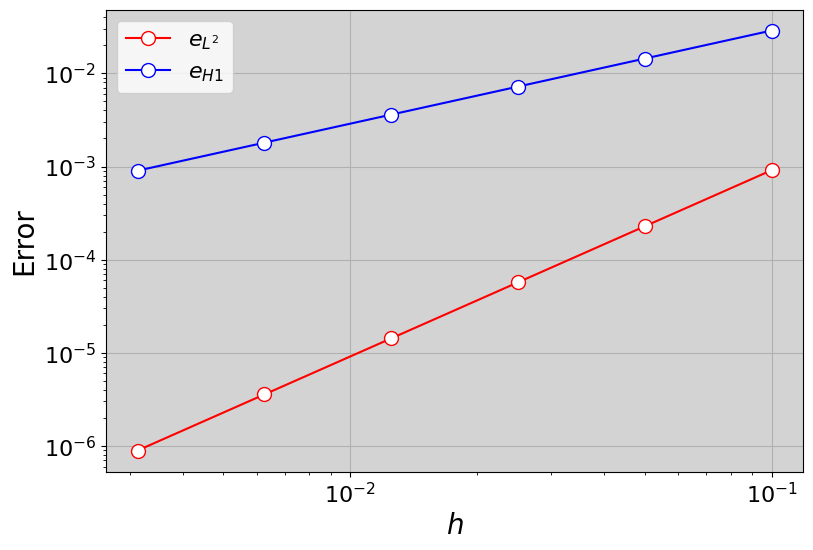

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize= (9,6))
plt.rcParams['font.size'] = '16'
plt.axes(facecolor = "lightgray")
plt.xlabel('$h$',fontsize=20)
plt.ylabel('Error', fontsize=20)
l = plt.plot(h, eL2,'-or', h, eH1, '-ob')
plt.setp(l, 'markersize', 10)
plt.setp(l, 'markerfacecolor', 'white')
plt.legend(['$e_{L^2}$', '$e_{H1}$'])
plt.loglog(base=10)
plt.grid()
plt.show()

# A more complex geometry: Poisson's multimaterial problem

We will use a more advance tool, the `gmsh` library to create a square domain with some internal inclusions, such that

\begin{equation}
            \mu(\mathbf{x}) = \left\{
            \begin{array}{r l l l }
            \mu_B & \mbox{if} & \mathbf{x} \in \Omega_{B} = \bigcup_{i=1}^{n_b} {\omega_i}, ~
            \omega_i = \{ \mathbf{x} \in \Omega, \parallel \mathbf{x} - \mathbf{x}_c^i \parallel < r_i  \}  \\
            ~\\
            \mu_A & \mbox{if} & \mathbf{x} \in \Omega_A = \Omega \setminus \Omega_{B}
            \end{array}
            \right.
  \end{equation}

To that end we must import the library first by doing:


In [19]:
ninclusions = 3
Lx = 2.0
Ly = 2.0
R1 = 0.25
R2 = 0.15
R3 = 0.25

def GenerateMesh():

    gmsh.initialize()
    proc = MPI.COMM_WORLD.rank

    mass1 = np.pi*R1**2
    mass2 = np.pi*R2**2
    mass3 = np.pi*R3**2
    mass_inc = mass1 + mass2 + mass3

    if proc == 0:
        # We create one rectangle and the circular inclusion
        background = gmsh.model.occ.addRectangle(0, 0, 0, Lx, Ly)
        inclusion1 = gmsh.model.occ.addDisk(0.5, 1.0, 0, R1, R1)
        inclusion2 = gmsh.model.occ.addDisk(1.0, 1.5, 0, R2, R2)
        inclusion3 = gmsh.model.occ.addDisk(1.5, 1.0, 0, R3, R3)
        gmsh.model.occ.synchronize()
        all_inclusions = [(2, inclusion1)]
        all_inclusions.extend([(2, inclusion2)])
        all_inclusions.extend([(2, inclusion3)])
        whole_domain = gmsh.model.occ.fragment([(2, background)], all_inclusions)
        gmsh.model.occ.synchronize()

        background_surfaces = []
        other_surfaces = []
        for domain in whole_domain[0]:
            com = gmsh.model.occ.getCenterOfMass(domain[0], domain[1])
            mass = gmsh.model.occ.getMass(domain[0], domain[1])
            #print(mass, com)
            # Identify the square by its mass
            if np.isclose(mass, (Lx*Ly - mass_inc)):
                gmsh.model.addPhysicalGroup(domain[0], [domain[1]], 0)
                background_surfaces.append(domain)
            elif np.isclose(np.linalg.norm(com), np.sqrt((0.5)**2 + (1.0)**2)):
                gmsh.model.addPhysicalGroup(domain[0], [domain[1]], 1)
                other_surfaces.append(domain)
            elif np.isclose(np.linalg.norm(com), np.sqrt((1.0)**2 + (1.5)**2)) and com[1] > 1.0:
                gmsh.model.addPhysicalGroup(domain[0], [domain[1]], 2)
                other_surfaces.append(domain)
            elif np.isclose(np.linalg.norm(com), np.sqrt((1.5)**2 + (1.0)**2)):
                gmsh.model.addPhysicalGroup(domain[0], [domain[1]], 3)
                other_surfaces.append(domain)

        # Tag the left and right boundaries
        left = []
        right = []
        for line in gmsh.model.getEntities(dim=1):
            com = gmsh.model.occ.getCenterOfMass(line[0], line[1])
            if np.isclose(com[0], 0.0):
                left.append(line[1])
            if np.isclose(com[0], Lx):
                right.append(line[1])
        gmsh.model.addPhysicalGroup(1, left, 3)
        gmsh.model.addPhysicalGroup(1, right,1)

    gmsh.model.mesh.setSize(gmsh.model.getEntities(0), 0.05)
    gmsh.model.mesh.generate(2)

    msh, subdomains, boundaries = io.gmshio.model_to_mesh(gmsh.model, comm=MPI.COMM_WORLD, rank=0, gdim=2)
    gmsh.finalize()
    return msh, subdomains, boundaries

msh, subdomains, boundaries = GenerateMesh()

with io.XDMFFile(MPI.COMM_WORLD, "mymesh.xdmf", "w") as xdmf:
    xdmf.write_mesh(msh)

plot_mesh(msh, cell_values=None, filename="mesh.html")
IPython.display.HTML(filename="mesh.html")

In order to define the diffusivity as a piecewise constant function we must introduce a `DG` space:


$$
Q_h = \{v \in L^2(\Omega),~v|_E \in P_0(E) \, \forall E \in \mathcal{T}_h\}
$$

which is done in `dolfinx` as

In [20]:
def SetDifus(msh, subdomains, muA, muB):
  Q = fem.functionspace(msh, ("DG", 0))
  muh = fem.Function(Q)

  # Identify cells with different tags
  cells_background = subdomains.indices[subdomains.values == 0]
  cells_inc = subdomains.indices[subdomains.values >= 1]

  # Set mu = muA in the background cells
  muh.x.array[cells_background] = np.full(len(cells_background), muA)

  # Set mu = muB in the inclusion celss
  muh.x.array[cells_inc] = np.full(len(cells_inc), muB)

  return muh

# Test the function
muA, muB = 1.0, 10000.0
muh = SetDifus(msh, subdomains, muA, muB)
muh.name = "mu"
with io.XDMFFile(MPI.COMM_WORLD, "mu.xdmf", "w") as xdmf:
    xdmf.write_mesh(msh)
    xdmf.write_function(muh)

plot_mesh(msh, cell_values=muh, filename="muvalues.html")
IPython.display.HTML(filename="muvalues.html")

In [21]:
def SolvePoissonMulti(msh, subdomains, muA, muB):

  dx = Measure("dx")(subdomain_data=subdomains)
  ds = Measure("ds")(subdomain_data=boundaries)

  # Sanity check
  if(False):
    # Compute the length and area for verification
    one = fem.Constant(msh, 1.0)
    for i in [1, 3]:
      length_form = fem.form( one*ds(i) )
      lengthside = fem.assemble_scalar(length_form)
      print(lengthside)

    total = 0.0
    for i in range(4):
      area_form = fem.form( one*dx(i) )
      area = fem.assemble_scalar(area_form)
      total += area
      print('Individual area of %d surface= %f' %(i,area))
    print('Total area=', total)

  degree = 1
  V = fem.functionspace(msh, ("CG", degree))
  dofsL = fem.locate_dofs_geometrical(V, lambda x: np.isclose(x[0], 0))
  dofsR = fem.locate_dofs_geometrical(V, lambda x: np.isclose(x[0], Lx))
  bcs = [fem.dirichletbc(ScalarType(uleft), dofsL, V), fem.dirichletbc(ScalarType(uright), dofsR, V)]

  u, v = TrialFunction(V), TestFunction(V)

  muh = SetDifus(msh, subdomains, muA, muB)

  a = inner(muh*grad(u), grad(v)) * dx
  source = fem.Constant(msh, 0.0)
  L = source * v * dx
  problem = fem.petsc.LinearProblem(a, L, bcs=bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu", "pc_factor_matsolver_type": "mumps"})
  uh = problem.solve()
  print('Solving problem with %d unknowns' %(V.dofmap.index_map.size_global))

  return uh

# Test the function
uh = SolvePoissonMulti(msh, subdomains, muA, muB)
uh.name = "Temperature"
with io.XDMFFile(MPI.COMM_WORLD, "inclusions.xdmf", "w") as xdmf:
    xdmf.write_mesh(msh)
    xdmf.write_function(uh)

from google.colab import files
files.download('inclusions.xdmf')
files.download('inclusions.h5')

Solving problem with 2054 unknowns


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---
# Homework 1

## Multimaterial problem

### Effective diffusivity

Taking $f = 0$, compute and the effective thermal diffusivity of the system
as function of $\mu_B/\mu_A$

\begin{equation}
\mu_{\mbox{eff}} = \frac{|q|/L_y}{|u_l - u_r|/L_x}  \nonumber
\end{equation}

where the amount of heat entering the system is given by

\begin{equation}
 q = \int_{ \Gamma_{\mbox{left}}}{\mu_A \nabla{u}_h \cdot \check{\mathbf{e}}_1}\,ds
 \end{equation}

 Complete the following code:

    muA = 1.0
    mueff = []
    n = FacetNormal(msh)
    ds = Measure("ds")(subdomain_data=boundaries)
    muBvals = [1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]
    for muB in muBvals:
      uh = SolvePoissonMulti(msh, subdomains, muA, muB)
      q = ...
      mueff.append(...)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize= (9,6))
plt.rcParams['font.size'] = '16'
plt.axes(facecolor = "lightgray")
plt.xlabel('$\mu_B/\mu_A$',fontsize=20)
plt.ylabel('$\mu_{eff}$', fontsize=20)
l = plt.plot(muBvals, mueff, '-or')
plt.setp(l, 'markersize', 10)
plt.setp(l, 'markerfacecolor', 'white')
plt.semilogx(base=10)
plt.grid()
plt.show()

### Average temperature of inclusions

Let consider $\mu_B \gg \mu_A$, such that the temperature
on each circular region is nearly uniform. Implement the computation of
the average temperature on each inclusion, i.e.,
 \begin{equation}
 \langle T_i \rangle = \frac{1}{|\omega_i|} \, \int_{\omega_i}{u(\mathbf{x})}\,d{x}
\end{equation}
in which $|\omega_i|$ stands for the the area of region $\omega_i$.

Complete the following code:

    dx = Measure("dx")(subdomain_data=subdomains)
    one = Constant(msh, 1.0)
    Tincav = []
    for k in range(ninclusions):
      area = assemble_scalar(fem.form(one * dx(k+1)))
      Tinc = assemble_scalar(...)
      Tincav.append(...)